In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/RUL_code"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
'Advance RUL.ipynb'   data   RUL.ipynb	 simple   utils.py


In [ ]:
!pip install composeml==0.3

In [ ]:
!pip install featuretools==0.16

In [ ]:
import composeml as cp
import numpy as np
import pandas as pd
import featuretools as ft
import utils
import os

from tqdm import tqdm
from sklearn.cluster import KMeans

2022-04-24 12:45:41,389 featuretools - WARNING    Featuretools failed to load plugin tsfresh from library featuretools_tsfresh_primitives.__init__. For a full stack trace, set logging to debug.


In [ ]:
data_path = 'gdrive/My Drive/RUL_code/data/train_FD004.txt'
data = utils.load_data(data_path)

data.head()

Loaded data with:
61249 Recordings
249 Engines
21 Sensor Measurements
3 Operational Settings


,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,index,time
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,0,2000-01-01 00:00:00
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,1,2000-01-01 00:10:00
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,2,2000-01-01 00:20:00
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,3,2000-01-01 00:30:00
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,4,2000-01-01 00:40:00


In [ ]:
def remaining_useful_life(df):
    return len(df) - 1

lm = cp.LabelMaker(
    target_entity='engine_no',
    time_index='time',
    labeling_function=remaining_useful_life,
)

label_times = lm.search(
    data.sort_values('time'),
    num_examples_per_instance=10,
    minimum_data=100,
    gap=10,
    verbose=True,
)

label_times.head()

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████| engine_no: 2490/2490 


,engine_no,time,remaining_useful_life
id,,,
0,1,2000-01-01 16:40:00,220
1,1,2000-01-01 18:20:00,210
2,1,2000-01-01 20:00:00,200
3,1,2000-01-01 21:40:00,190
4,1,2000-01-01 23:20:00,180


In [ ]:
splits = 5
cutoff_time_list = []

for i in range(splits):
    sample = label_times.sample(n=249, random_state=i)
    sample.sort_index(inplace=True)
    cutoff_time_list.append(sample)

cutoff_time_list[0].head()

,engine_no,time,remaining_useful_life
id,,,
1,1,2000-01-01 18:20:00,210
9,1,2000-01-02 07:40:00,130
10,2,2000-01-03 22:10:00,198
14,2,2000-01-04 04:50:00,158
27,3,2000-01-06 11:40:00,136


In [ ]:
nclusters = 50

def make_entityset(data, nclusters, kmeans=None):
    X = data[[
        'operational_setting_1',
        'operational_setting_2',
        'operational_setting_3',
    ]]

    if kmeans is None:
        kmeans = KMeans(n_clusters=nclusters).fit(X)

    data['settings_clusters'] = kmeans.predict(X)

    es = ft.EntitySet('Dataset')

    es.entity_from_dataframe(
        dataframe=data,
        entity_id='recordings',
        index='index',
        time_index='time',
    )

    es.normalize_entity(
        base_entity_id='recordings',
        new_entity_id='engines',
        index='engine_no',
    )

    es.normalize_entity(
        base_entity_id='recordings',
        new_entity_id='settings_clusters',
        index='settings_clusters',
    )

    return es, kmeans


es, kmeans = make_entityset(data, nclusters)
es


Entityset: Dataset
  Entities:
    recordings [Rows: 61249, Columns: 29]
    engines [Rows: 249, Columns: 2]
    settings_clusters [Rows: 50, Columns: 2]
  Relationships:
    recordings.engine_no -> engines.engine_no
    recordings.settings_clusters -> settings_clusters.settings_clusters

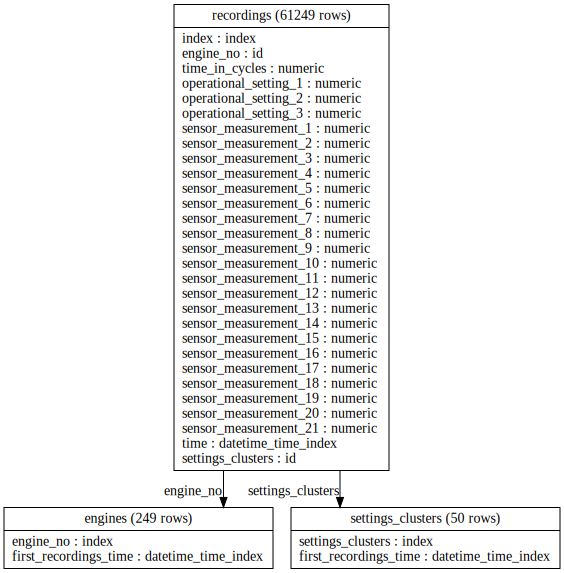

In [ ]:
es.plot()

In [ ]:
from featuretools_tsfresh_primitives import CidCe

fm, features = ft.dfs(
    entityset=es,
    target_entity='engines',
    agg_primitives=['last', 'max', CidCe(normalize=False)],
    trans_primitives=[],
    chunk_size=.26,
    cutoff_time=cutoff_time_list[0],
    max_depth=3,
    verbose=True,
)


Built 304 features
Elapsed: 02:23 | Progress: 100%|██████████


In [ ]:
fm.to_csv('advanced_fm.csv')

fm.head()

,LAST(recordings.sensor_measurement_19),LAST(recordings.sensor_measurement_7),LAST(recordings.index),LAST(recordings.sensor_measurement_6),LAST(recordings.sensor_measurement_11),LAST(recordings.operational_setting_1),LAST(recordings.settings_clusters),LAST(recordings.sensor_measurement_20),LAST(recordings.sensor_measurement_16),LAST(recordings.sensor_measurement_5),...,"CID_CE(recordings.settings_clusters.CID_CE(recordings.sensor_measurement_19, normalize=False), normalize=False)","CID_CE(recordings.settings_clusters.MAX(recordings.sensor_measurement_4), normalize=False)","CID_CE(recordings.settings_clusters.MAX(recordings.sensor_measurement_19), normalize=False)","CID_CE(recordings.settings_clusters.MAX(recordings.sensor_measurement_18), normalize=False)","CID_CE(recordings.settings_clusters.CID_CE(recordings.sensor_measurement_15, normalize=False), normalize=False)","CID_CE(recordings.settings_clusters.MAX(recordings.sensor_measurement_21), normalize=False)","CID_CE(recordings.settings_clusters.MAX(recordings.time_in_cycles), normalize=False)","CID_CE(recordings.settings_clusters.CID_CE(recordings.sensor_measurement_5, normalize=False), normalize=False)","CID_CE(recordings.settings_clusters.CID_CE(recordings.sensor_measurement_20, normalize=False), normalize=False)",remaining_useful_life
engine_no,,,,,,,,,,,,,,,,,,,,,
1,100.0,138.03,110,5.69,41.80,42.0072,12,10.65,0.02,3.91,...,0.0,1694.984047,79.742945,2161.576277,0.507311,84.184856,331.950297,0.0,2.566298,210
1,100.0,138.57,190,5.70,41.71,42.0059,49,10.75,0.02,3.91,...,0.0,2221.257136,106.560992,2844.522104,0.757496,108.652309,647.671213,0.0,2.939048,130
2,100.0,195.02,421,8.00,41.81,34.9989,9,14.77,0.02,5.48,...,0.0,1631.080732,73.827621,1981.216041,0.880971,81.299187,868.305822,0.0,2.955539,198
2,100.0,194.74,461,8.00,41.81,35.0072,19,15.02,0.02,5.48,...,0.0,1891.042042,90.420000,2388.702786,1.033860,93.380032,1026.519849,0.0,3.351265,158
3,100.0,557.81,790,21.60,47.27,0.0026,0,39.17,0.03,14.62,...,0.0,2315.109337,110.741431,2940.397252,1.077339,111.346345,551.945649,0.0,4.048741,136


In [ ]:
fm_list = [fm]

for i in tqdm(range(1, splits)):
    es = make_entityset(data, nclusters, kmeans=kmeans)[0]
    fm = ft.calculate_feature_matrix(
        entityset=es,
        features=features,
        chunk_size=.26,
        cutoff_time=cutoff_time_list[i],
    )
    fm_list.append(fm)

100%|██████████| 4/4 [07:56<00:00, 119.15s/it]


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE

In [ ]:
def pipeline_for_test(fm_list, hyperparams=None, do_selection=False):
    scores = []
    regs = []
    selectors = []

    hyperparams = hyperparams or {
        'n_estimators': 100,
        'max_feats': 50,
        'nfeats': 50,
    }

    for fm in fm_list:
        X = fm.copy().fillna(0)
        y = X.pop('remaining_useful_life')

        n_estimators = int(hyperparams['n_estimators'])
        max_features = int(hyperparams['max_feats'])
        max_features = min(max_features, int(hyperparams['nfeats']))
        reg = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features)

        X_train, X_test, y_train, y_test = train_test_split(X, y)

        if do_selection:
            reg2 = RandomForestRegressor(n_estimators=10, n_jobs=3)
            selector = RFE(reg2,  step=25)
            selector.fit(X_train, y_train)
            X_train = selector.transform(X_train)
            X_test = selector.transform(X_test)
            selectors.append(selector)

        reg.fit(X_train, y_train)
        regs.append(reg)

        preds = reg.predict(X_test)
        mae = mean_absolute_error(preds, y_test)
        scores.append(mae)

    return scores, regs, selectors


scores, regs, selectors = pipeline_for_test(fm_list)
print([float('{:.1f}'.format(score)) for score in scores])

mean, std = np.mean(scores), np.std(scores)
info = 'Average MAE: {:.1f}, Std: {:.2f}\n'
print(info.format(mean, std))

most_imp_feats = utils.feature_importances(fm_list[0], regs[0])

[39.8, 35.6, 35.8, 33.5, 35.9]
Average MAE: 36.1, Std: 2.02

1: LAST(recordings.settings_clusters.LAST(recordings.sensor_measurement_1)) [0.143]
2: LAST(recordings.sensor_measurement_21) [0.107]
3: LAST(recordings.sensor_measurement_1) [0.066]
4: LAST(recordings.settings_clusters.CID_CE(recordings.sensor_measurement_14, normalize=False)) [0.061]
5: LAST(recordings.settings_clusters.MAX(recordings.sensor_measurement_3)) [0.057]
-----



In [ ]:
data_test = utils.load_data('gdrive/My Drive/RUL_code/data/test_FD004.txt')

es_test, _ = make_entityset(
    data_test,
    nclusters,
    kmeans=kmeans,
)

fm_test = ft.calculate_feature_matrix(
    entityset=es_test,
    features=features,
    verbose=True,
    chunk_size=.26,
)

X = fm_test.copy().fillna(0)

y = pd.read_csv(
    'gdrive/My Drive/RUL_code/data/RUL_FD004.txt',
    sep=' ',
    header=None,
    names=['remaining_useful_life'],
    index_col=False,
)

preds = regs[0].predict(X)
mae = mean_absolute_error(preds, y)
print('Mean Abs Error: {:.2f}'.format(mae))

Loaded data with:
41214 Recordings
248 Engines
21 Sensor Measurements
3 Operational Settings
Elapsed: 00:03 | Progress: 100%|██████████
Mean Abs Error: 30.43


In [ ]:
!pip install baytune==0.2.5

In [ ]:
from btb import HyperParameter, ParamTypes
from btb.tuning import GP

def run_btb(fm_list, n=30, best=45):
    hyperparam_ranges = [
        ('n_estimators', HyperParameter(ParamTypes.INT, [10, 200])),
        ('max_feats', HyperParameter(ParamTypes.INT, [5, 50])),
        ('nfeats', HyperParameter(ParamTypes.INT, [10, 70])),
    ]

    tuner = GP(hyperparam_ranges)
    shape = (n, len(hyperparam_ranges))
    tested_parameters = np.zeros(shape, dtype=object)
    scores = []

    print('[n_est, max_feats, nfeats]')

    best_hyperparams = None
    best_sel = None
    best_reg = None

    for i in tqdm(range(n)):
        hyperparams = tuner.propose()

        cvscores, regs, selectors = pipeline_for_test(
            fm_list,
            hyperparams=hyperparams,
            do_selection=True,
        )

        bound = np.mean(cvscores)
        tested_parameters[i, :] = hyperparams
        tuner.add(hyperparams, -np.mean(cvscores))

        if np.mean(cvscores) + np.std(cvscores) < best:
            best = np.mean(cvscores)
            best_hyperparams = hyperparams
            best_reg = regs[0]
            best_sel = selectors[0]

            info = '{}. {} -- Average MAE: {:.1f}, Std: {:.2f}'
            mean, std = np.mean(cvscores), np.std(cvscores)
            print(info.format(i, best_hyperparams, mean, std))
            print('Raw: {}'.format([float('{:.1f}'.format(s)) for s in cvscores]))

    return best_hyperparams, (best_sel, best_reg)   

best_hyperparams, best_pipeline = run_btb(fm_list, n=30)

[n_est, max_feats, nfeats]


  3%|▎         | 1/30 [00:14<06:54, 14.30s/it]

0. {'n_estimators': 46, 'max_feats': 26, 'nfeats': 49} -- Average MAE: 39.9, Std: 4.73
Raw: [38.9, 34.7, 45.6, 45.2, 35.0]


  7%|▋         | 2/30 [00:28<06:36, 14.17s/it]/usr/local/lib/python3.7/dist-packages/btb/tuning/gp.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(list(zip(y, stdev)))
 10%|█         | 3/30 [00:44<06:41, 14.86s/it]

2. {'n_estimators': 48, 'max_feats': 27, 'nfeats': 43} -- Average MAE: 34.7, Std: 4.80
Raw: [39.3, 36.0, 30.9, 39.9, 27.6]


/usr/local/lib/python3.7/dist-packages/btb/tuning/gp.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(list(zip(y, stdev)))
 13%|█▎        | 4/30 [01:01<06:51, 15.81s/it]/usr/local/lib/python3.7/dist-packages/btb/tuning/gp.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(list(zip(y, stdev)))
 17%|█▋        | 5/30 [01:15<06:20, 15.22s/it]/usr/local/lib/python3.7/dist-packages/btb/tuning/gp.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tupl

In [ ]:
X = fm_test.copy().fillna(0)

y = pd.read_csv(
    'gdrive/My Drive/RUL_code/data/RUL_FD004.txt',
    sep=' ',
    header=None,
    names=['remaining_useful_life'],
    index_col=False,
)

preds = best_pipeline[1].predict(best_pipeline[0].transform(X))
score = mean_absolute_error(preds, y)
print('Mean Abs Error on Test: {:.2f}'.format(score))

most_imp_feats = utils.feature_importances(
    X.iloc[:, best_pipeline[0].support_],
    best_pipeline[1],
)

Mean Abs Error on Test: 32.28
1: MAX(recordings.settings_clusters.LAST(recordings.sensor_measurement_13)) [0.142]
2: MAX(recordings.sensor_measurement_13) [0.110]
3: MAX(recordings.settings_clusters.LAST(recordings.sensor_measurement_4)) [0.077]
4: MAX(recordings.settings_clusters.LAST(recordings.sensor_measurement_11)) [0.050]
5: MAX(recordings.sensor_measurement_11) [0.048]
-----



In [ ]:
from featuretools.primitives import Min

old_fm, features = ft.dfs(
    entityset=es,
    target_entity='engines',
    agg_primitives=['last', 'max', 'min'],
    trans_primitives=[],
    cutoff_time=cutoff_time_list[0],
    max_depth=3,
    verbose=True,
)

old_fm_list = [old_fm]

for i in tqdm(range(1, splits)):
    es = make_entityset(data, nclusters, kmeans=kmeans)[0]
    old_fm = ft.calculate_feature_matrix(
        entityset=es,
        features=features,
        cutoff_time=cutoff_time_list[i],
    )
    old_fm_list.append(fm)

old_scores = []
median_scores = []

for fm in old_fm_list:
    X = fm.copy().fillna(0)
    y = X.pop('remaining_useful_life')

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    reg = RandomForestRegressor(n_estimators=10)
    reg.fit(X_train, y_train)
    preds = reg.predict(X_test)

    mae = mean_absolute_error(preds, y_test)
    old_scores.append(mae)

    medianpredict = [np.median(y_train) for _ in y_test]
    mae = mean_absolute_error(medianpredict, y_test)
    median_scores.append(mae)

print([float('{:.1f}'.format(score)) for score in old_scores])
mean, std = np.mean(old_scores), np.std(old_scores)
info = 'Average MAE: {:.2f}, Std: {:.2f}\n'
print(info.format(mean, std))

print([float('{:.1f}'.format(score)) for score in median_scores])
mean, std = np.mean(median_scores), np.std(median_scores)
info = 'Baseline by Median MAE: {:.2f}, Std: {:.2f}\n'
print(info.format(mean, std))

Built 304 features
Elapsed: 01:45 | Progress: 100%|██████████


100%|██████████| 4/4 [06:32<00:00, 98.23s/it]


[38.6, 31.9, 35.0, 31.5, 39.8]
Average MAE: 35.36, Std: 3.37

[65.4, 54.2, 48.9, 49.1, 52.0]
Baseline by Median MAE: 53.90, Std: 6.08



In [ ]:
y = pd.read_csv(
    'gdrive/My Drive/RUL_code/data/RUL_FD004.txt',
    sep=' ',
    header=None,
    names=['remaining_useful_life'],
    index_col=False,
)

median_scores_2 = []

for ct in cutoff_time_list:
    medianpredict2 = [np.median(ct['remaining_useful_life'].values) for _ in y.values]
    mae = mean_absolute_error(medianpredict2, y)
    median_scores_2.append(mae)

print([float('{:.1f}'.format(score)) for score in median_scores_2])
mean, std = np.mean(median_scores_2), np.std(median_scores_2)
info = 'Baseline by Median MAE: {:.2f}, Std: {:.2f}\n'
print(info.format(mean, std))

[47.4, 48.1, 47.4, 46.7, 46.5]
Baseline by Median MAE: 47.18, Std: 0.58



In [ ]:
# Save output files
os.makedirs("output", exist_ok=True)
fm.to_csv('output/advanced_train_feature_matrix.csv')
cutoff_time_list[0].to_csv('output/advanced_train_label_times.csv')
fm_test.to_csv('output/advanced_test_feature_matrix.csv')